# Zillow's Home Value Prediction (Zestimate) #

## Load Packages ##

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import gmplot
from IPython.display import Image

import gc

import missingno as msno 

from sklearn.model_selection import train_test_split

from datetime import datetime 

from sklearn.feature_extraction import FeatureHasher
               
np.random.seed(0)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Load Data ##

In [2]:
working_dir = "/home/lee/Documents/Datasets for GitHub/kaggle_zillow_home_value_prediction/"
df_train = pd.read_pickle(working_dir+'df_labeled_raw_train.pkl')

## EDA ##

### Check Missing ###

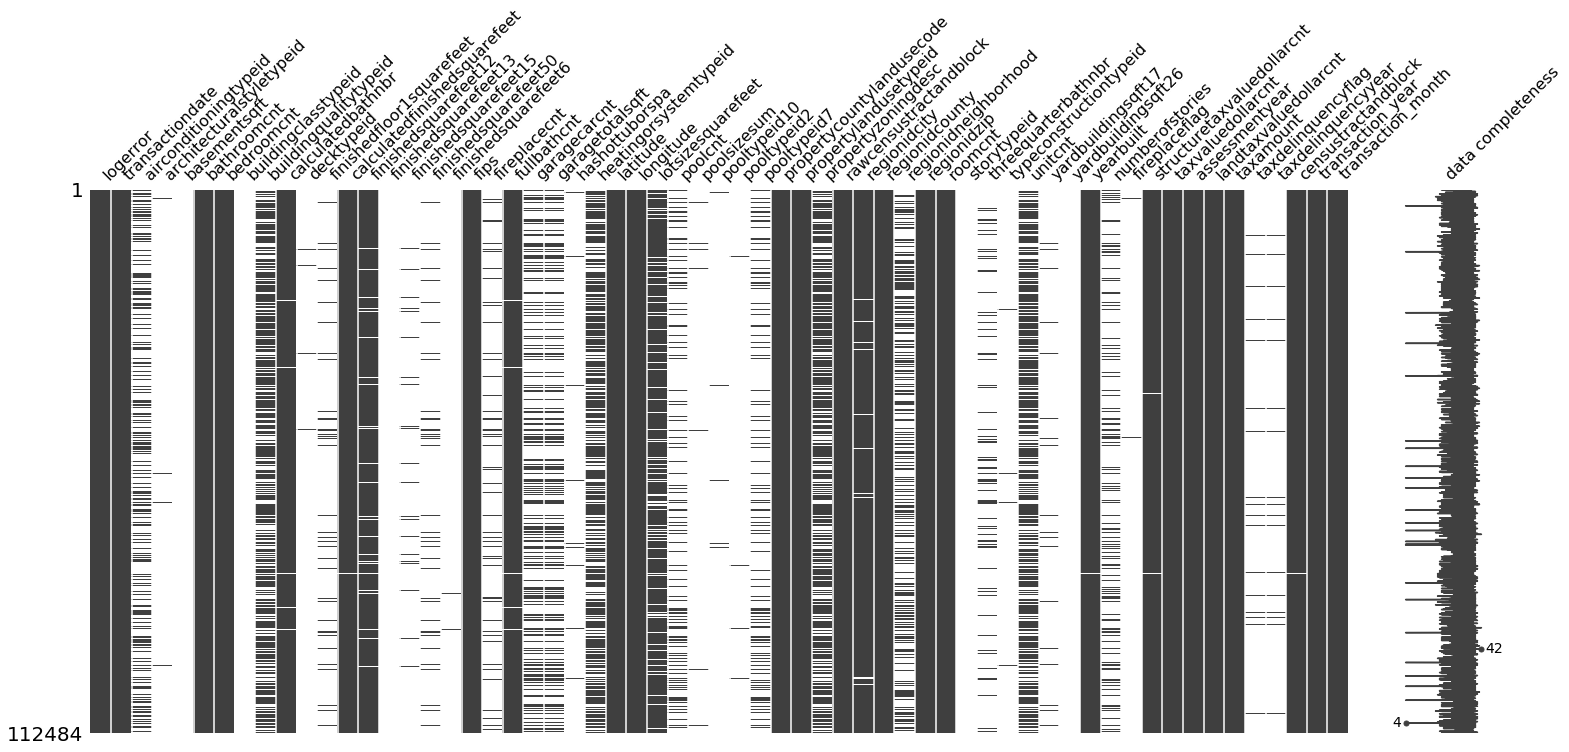

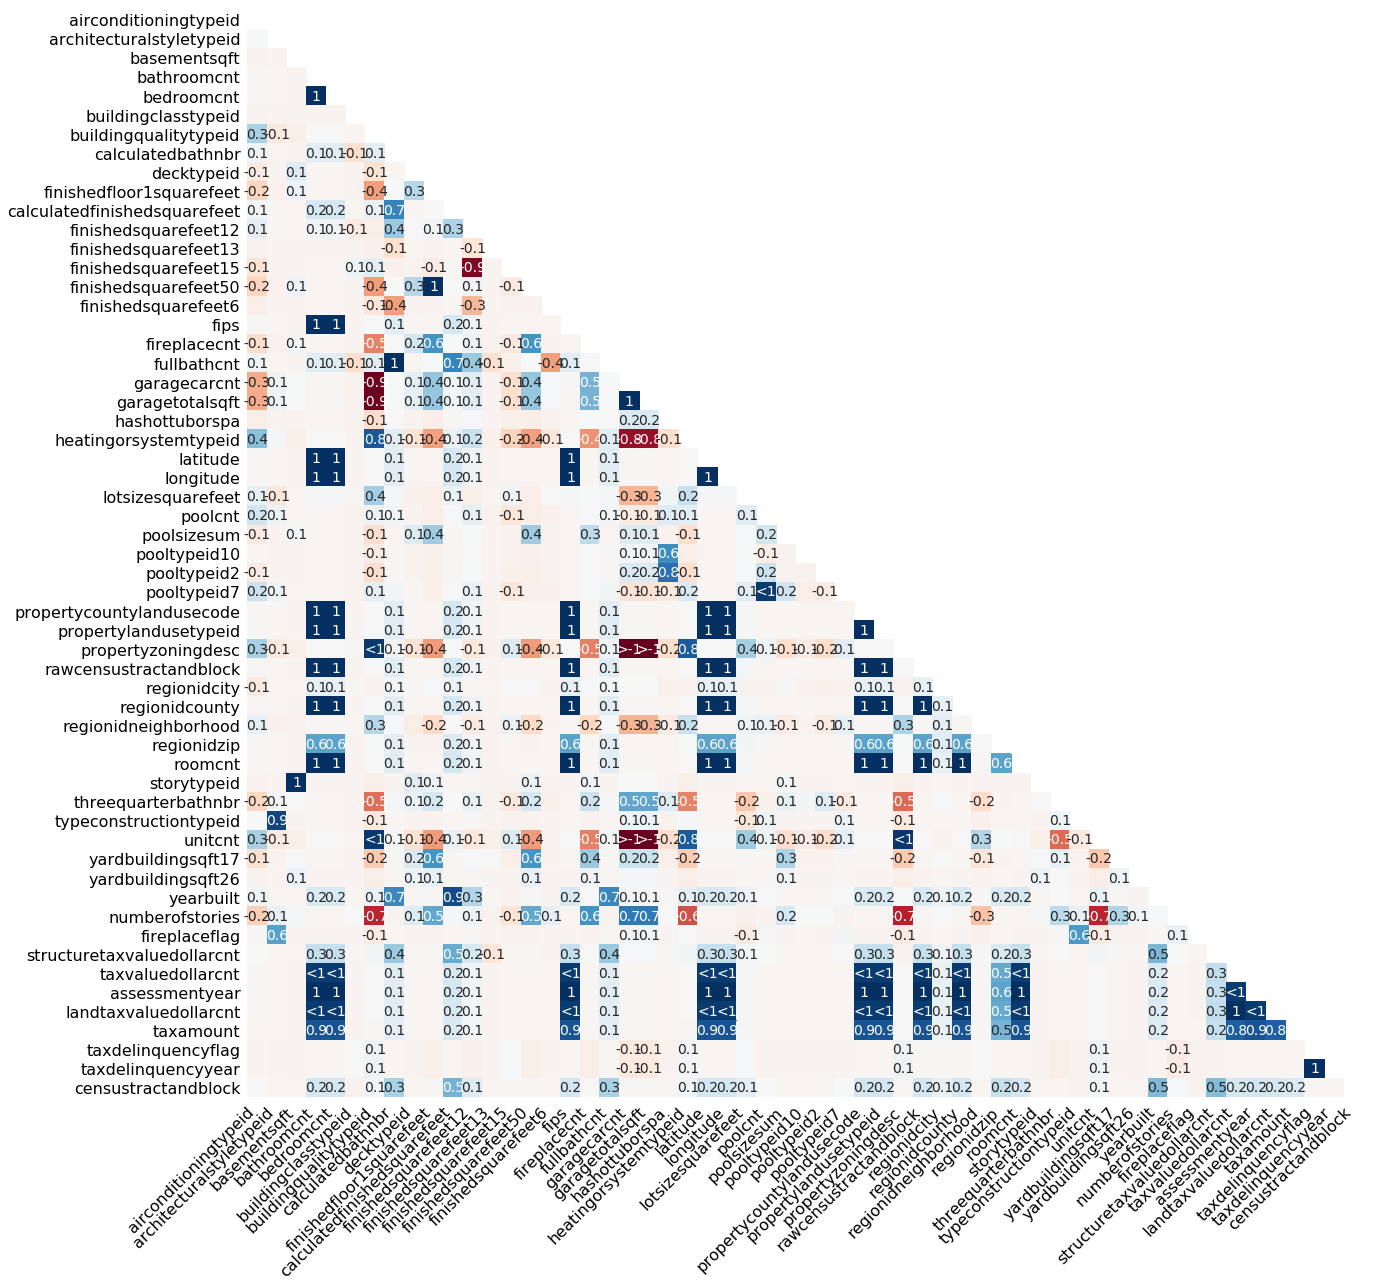

In [4]:
msno.matrix(df_train, sparkline=True, labels=True)
msno.heatmap(df_train, figsize=(20,20))

Some features, such as `basementsqft`, have significant missingness. Later we exclude the features with too many missing values. 

### Distribution of Features and Target ###

First look at the distribution of the target, log error. 

In [10]:
# plt.figure(figsize=(12, 8))
# sns.distplot(df_train['logerror'], bins=50, kde=False)
# plt.xlabel('logerror', fontsize=12)
# plt.title("Distribution of log error, original")
# plt.show()

Log error has some extreme values at both end of its range. Let's create the histogram with those extreme values capped at 1st and 99th percentiles.

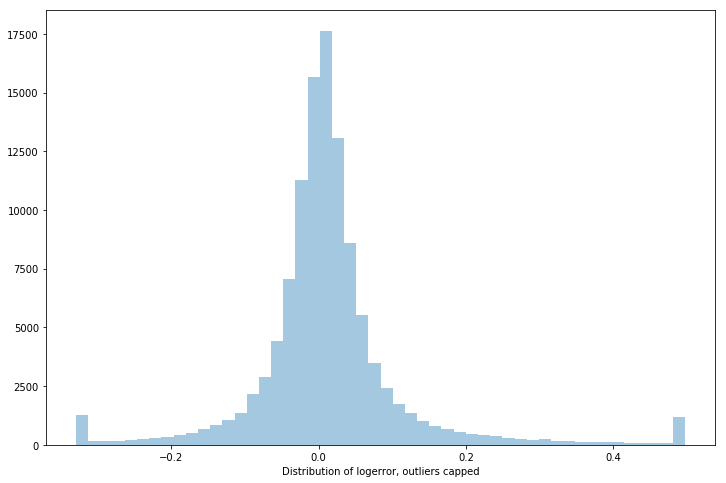

In [3]:
plot_logerror = df_train['logerror'].copy()
ulimit = np.percentile(plot_logerror.values, 99)
llimit = np.percentile(plot_logerror.values, 1)
plot_logerror.loc[plot_logerror > ulimit] = ulimit
plot_logerror.loc[plot_logerror < llimit] = llimit

plt.figure(figsize=(12, 8))
sns.distplot(plot_logerror, bins=50, kde=False)
plt.xlabel('Distribution of logerror, outliers capped')
plt.show()

del plot_logerror, ulimit, llimit 

The distribution is symmetric and centered at 0. Seems we do not need to transform the target variable. 

We know that house sales usually have a strong seasonality. How does the time trend look like?

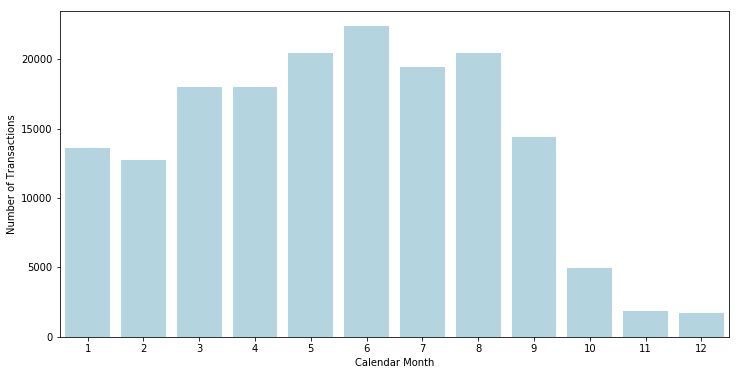

In [12]:
transaction_cnt_month = df_train['transaction_month'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(transaction_cnt_month.index, transaction_cnt_month.values, color='lightblue')
plt.xlabel('Calendar Month')
plt.ylabel('Number of Transactions')
plt.show()

del transaction_cnt_month

Data description states that some October, November, and December house sales were reserved as test data. The number of transactions indeed varies from January through September. 

How are the house scattered on a map?

In [13]:
zoom_level = 5
gmap = gmplot.GoogleMapPlotter.from_geocode("Los Angeles, CA, US", zoom_level)

Note: putting all houses on a map crashes my browser. Randomly pick some records to show on the map. 

In [14]:
gmap_sample = df_train.sample(n=1000) 
gmap.heatmap(gmap_sample['latitude']/1e6, gmap_sample['longitude']/1e6)
gmap.draw(working_dir+"Los_Angeles_properties_heatmap.html")

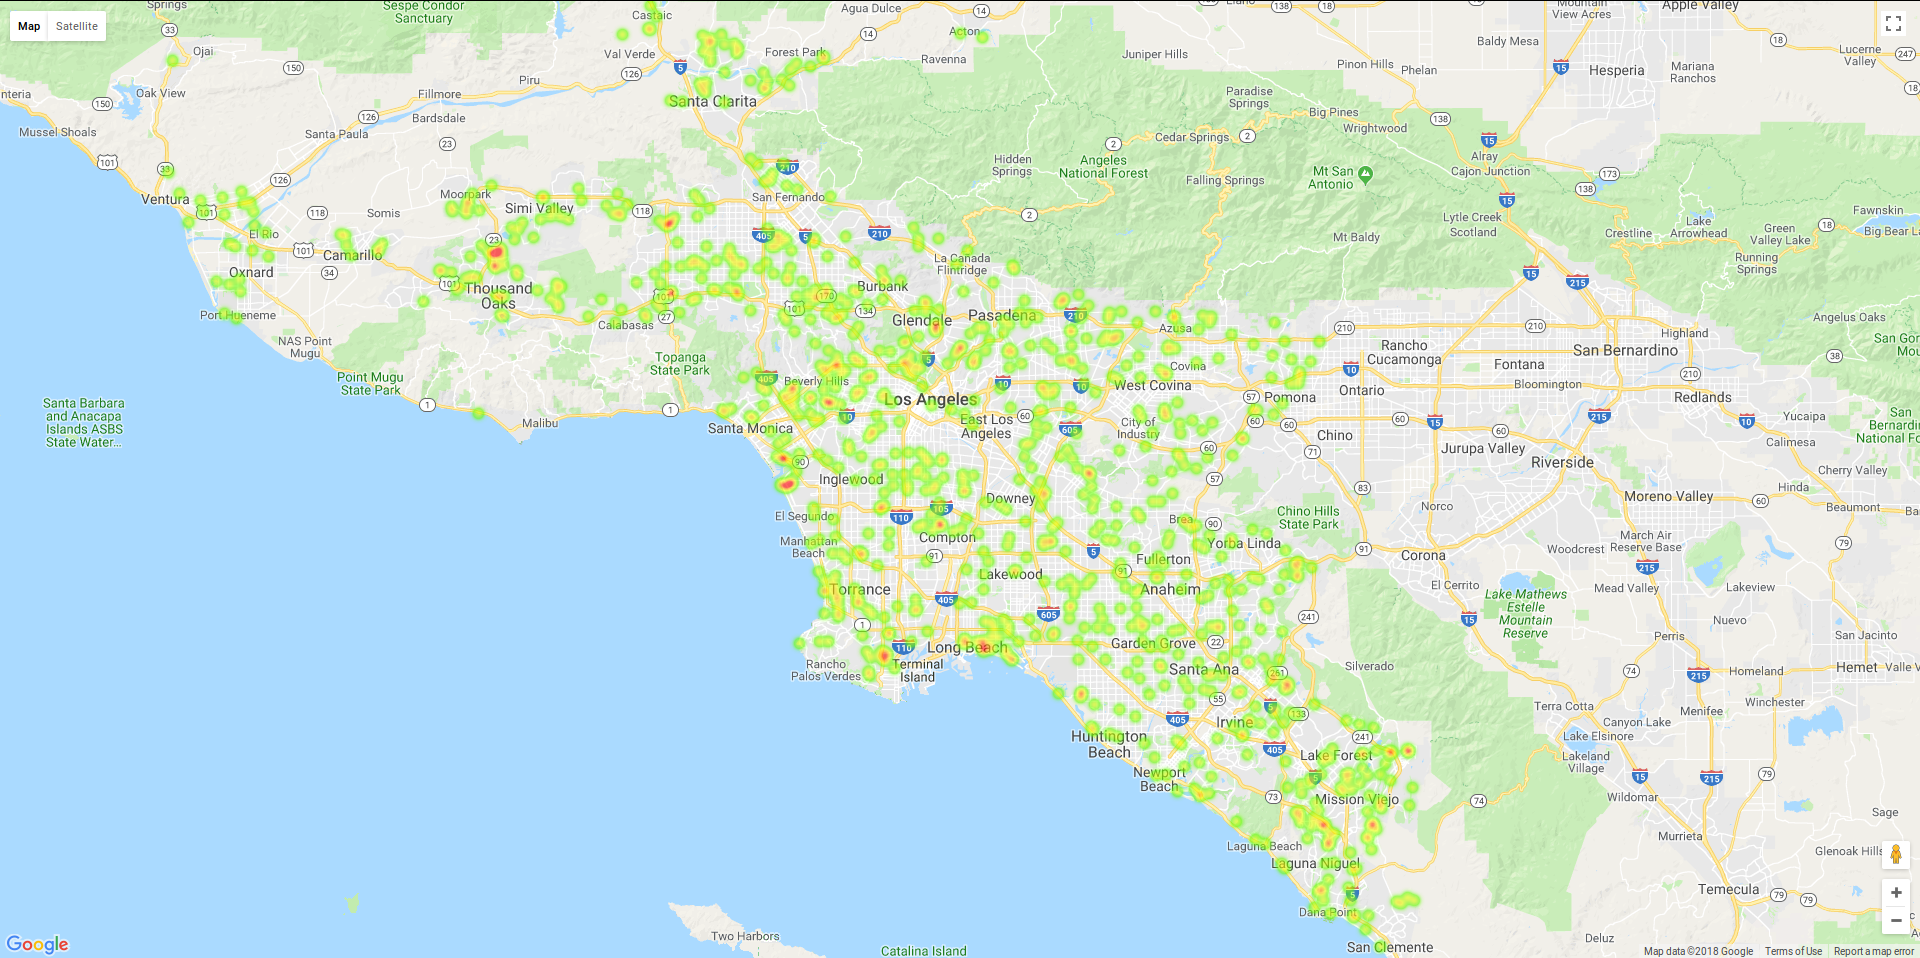

In [15]:
Image(working_dir+"2018-07-25-014309_1920x958_scrot.png", embed=True)

The houses are almost evenly distributed in Los Angeles county. Orange and Ventura appear to have fewer house sales. 

In [16]:
del zoom_level, gmap, gmap_sample
gc.collect()

8244

Common factors that influence house prices: usually the strongest determining factor of house price is the square footage. What is its relationship with log error?

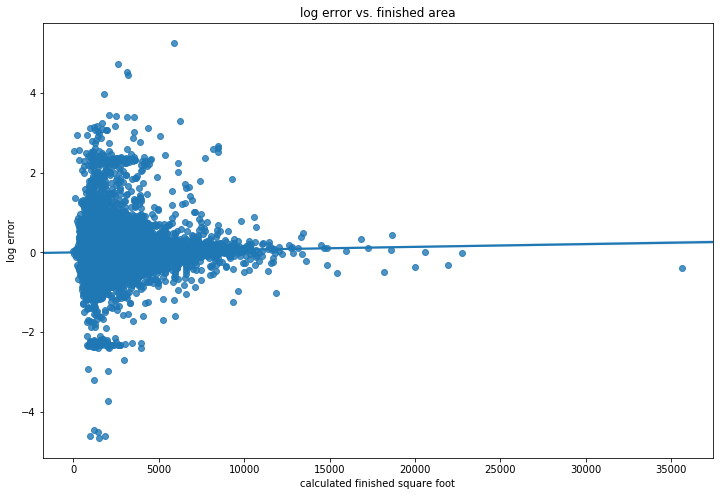

In [17]:
plt.figure(figsize=(12, 8))
sns.regplot(x="calculatedfinishedsquarefeet", y="logerror", data=df_train)
plt.ylabel('log error')
plt.xlabel('calculated finished square foot')
plt.title("log error vs. finished area")
plt.show()

Most of the houses are smaller than 10000 square feet. No correlation between log error and finished square footage. 

Now, number of bathrooms:

In [18]:
# plt.figure(figsize=(12, 8))
# sns.boxplot(x="bathroomcnt", y="logerror", data=df_train_2016)
# plt.ylabel('log error')
# plt.xlabel('bathroom count')
# plt.title("log error vs. bathroom count")
# plt.show()

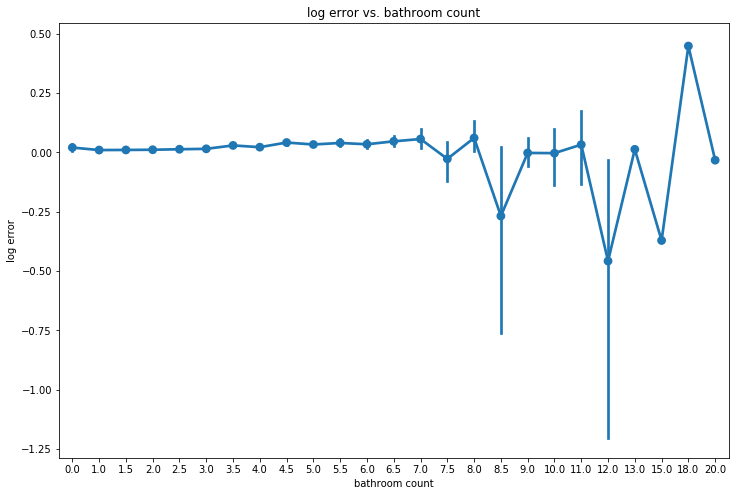

In [19]:
plt.figure(figsize=(12, 8))
sns.pointplot(x="bathroomcnt", y="logerror", data=df_train)
plt.ylabel('log error')
plt.xlabel('bathroom count')
plt.title("log error vs. bathroom count")
plt.show()

Log error starts showing large error bars in houses with more than 7 bathrooms but most houses are smaller than that. Overall no correlation between log error and number of bathrooms. 

Now number of bedrooms:

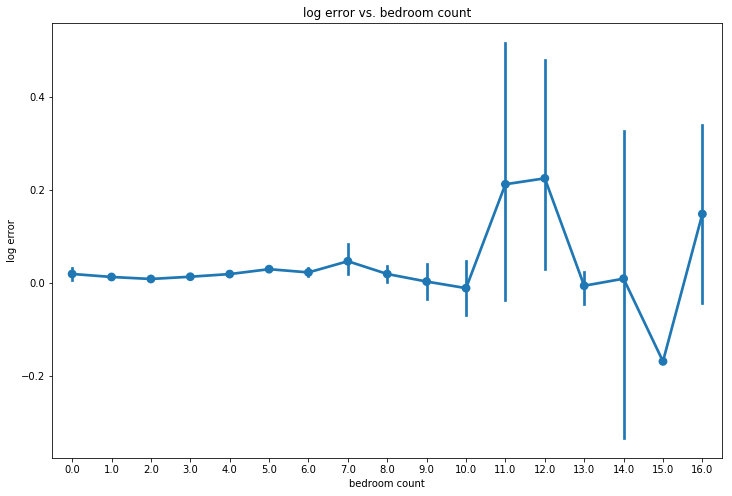

In [20]:
plt.figure(figsize=(12, 8))
sns.pointplot(x="bedroomcnt", y="logerror", data=df_train)
plt.ylabel('log error')
plt.xlabel('bedroom count')
plt.title("log error vs. bedroom count")
plt.show()

Similar to the relationship between log error and number of bathrooms - overall no correlation is observed. 

### Correlation ###

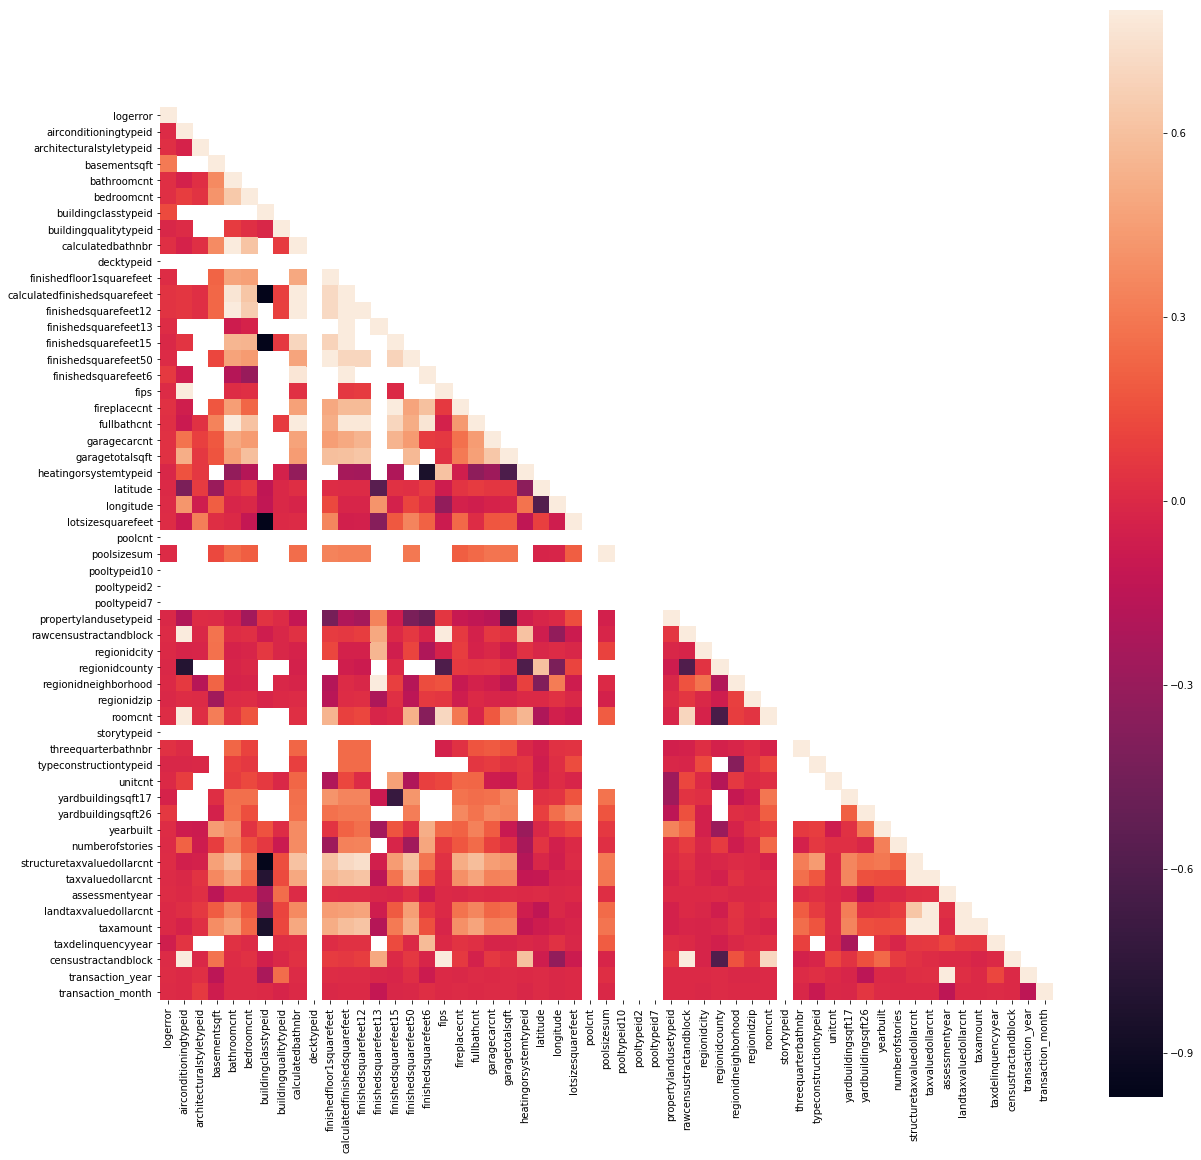

In [9]:
corrMatt = df_train.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,20)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True)

Most features are weakly correlated with others, with correlation coefficient between -0.3 and 0.3. The strongly negative correlations prompt us to check multicollinearity. 

### Multicollinearity ###

[Text(0,0.5,'Features'),
 Text(0.5,0,'VIF Scores'),
 Text(0.5,1,'Variables Which Exhibit Multicollinearity')]

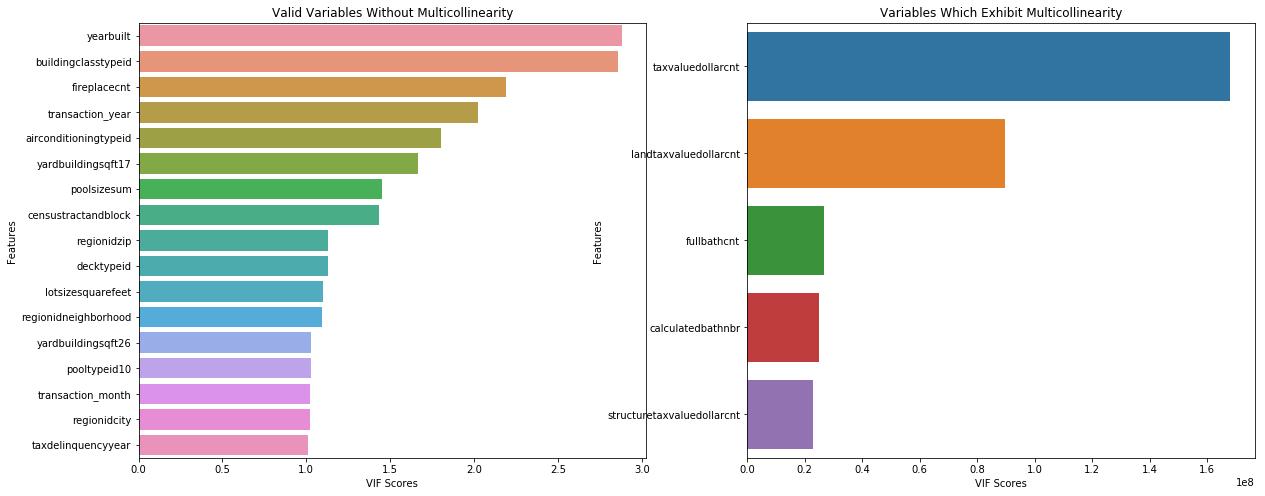

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import warnings
warnings.filterwarnings("ignore")

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

numericalCol = []
for f in df_train.columns:
    #print (f)
    if df_train[f].dtype!='object' and f not in ["parcelid", "transactiondate", "logerror"]:
        numericalCol.append(f)
mergedFilterd = df_train[numericalCol].fillna(-999) # fill value is arbitrary but -999 is rumored to lead to a better final score
vifDict = calculate_vif_(mergedFilterd)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,8)
sns.barplot(data=validVariables, x="vifScore", y="variables", ax=ax1, orient="h")
sns.barplot(data=variablesWithMC.head(5), x="vifScore", y="variables", ax=ax2,orient="h")
ax1.set(xlabel='VIF Scores', ylabel='Features', title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='VIF Scores', ylabel='Features', title="Variables Which Exhibit Multicollinearity")